In [26]:

"""
월 차트 조회
"""
import pandas as pd

from core.repository.maria.conn import maria_home

month_chart = pd.read_sql("""
select month_chart.*, stock.name, stock.exchange
from month_chart
join stock on substring(month_chart.code, -6) = stock.code;
""", maria_home())

month_chart["code"] = month_chart["code"].apply(lambda code: code[-6:])
month_chart

,code,date,open,high,low,close,vol,vol_lastday,cap,name,exchange
0,010640,1996-01-31,426,571,426,540,8578133,402317,142928000000,진양폴리,KOSPI
1,000325,1996-01-31,615,624,520,594,143596,67591,724000000,노루홀딩스우,KOSPI
2,003060,1996-01-31,159638,218635,146624,217767,2756,950,3484000000,에이프로젠바이오로직스,KOSPI
3,006280,1996-01-31,51233,64561,45401,64561,165110,13367,37122000000,녹십자,KOSPI
4,012330,1996-01-31,8449,9277,8007,8394,774650,26275,350054000000,현대모비스,KOSPI
...,...,...,...,...,...,...,...,...,...,...,...
470476,005710,2022-12-02,5740,5820,5710,5780,17084,5917,115813000000,대원산업,KOSDAQ
470477,062970,2022-12-02,3010,3080,2915,3000,54040,26654,27924000000,피피아이,KOSDAQ
470478,290550,2022-12-02,8860,9190,8810,8840,48733,15270,145524000000,디케이티,KOSDAQ
470479,009415,2022-12-02,9350,10350,7900,7900,167222,35788,10285000000,태영건설우,KOSPI


In [25]:
"""
"""
import pandas as pd
from core.repository import load_financial
from base.timeutil import YearMonth
import sqlite3

try:
    raise Exception()
    layer1 = pd.read_sql("select * from layer1", sqlite3.connect(".cache/cache.db"))
except:
    begin = YearMonth(2002, 6)
    end = YearMonth(2022, 11)

    month_chart["년월"] = [YearMonth.of(d) for d in month_chart["date"]]
    layer1 = pd.DataFrame()
    for ym1, ym2 in [(row.iloc[0], row.iloc[1]) for row in pd.Series(begin.iter(end)).rolling(2) if len(row) == 2]:
        print(f"\r{ym1} {ym2}", end="\r")
        df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
        # 당일 1000만원 이상 거래 발생 종목만 취급
        df1 = df1[df1["cap"] != 0]
        df1 = df1[df1["vol"] * df1["close"] > 1_000_0000]
        df1 = df1[df1["vol_lastday"] * df1["close"] > 1_000_0000]
        df2 = month_chart[month_chart["년월"] == ym2].set_index("code")

        df = pd.DataFrame({
            "종목명": df1["name"],
            "거래소": df1["exchange"],
            "매수년월": str(ym1),
            "매도년월": str(ym2),
            "시가총액": df1["cap"],
            "매수일": df1["date"],
            "매수가": df1["close"],
            "거래량": df1["vol"],
        })

        df["매도가"] = df2["close"]
        df["매도일"] = df2["date"]
        df["수익률"] = df["매도가"] / df["매수가"] - 1

        # 재무데이터 조인하여 layer1에 반영
        fn = load_financial(ym1.year, ym1.month)
        layer1 = pd.concat([layer1, df.join(fn)])

    layer1 = layer1.reset_index()
    layer1["확정실적"] = str(layer1["확정실적"])
    layer1.to_sql("layer1", sqlite3.connect(".cache/cache.db"), if_exists="replace", index=False)

layer1

,code,종목명,거래소,매수년월,매도년월,시가총액,매수일,매수가,거래량,매도가,...,매출총이익,영업이익,당기순이익,GP_YoY,O_YoY,E_YoY,GP_QoQ,O_QoQ,E_QoQ,확정실적
0,001750,한양증권,KOSPI,2002-06,2002-07,48366000000,2002-06-28,3800,459290,3810.0,...,NaN,1.223689e+10,NaN,NaN,1.249352,NaN,NaN,0.237975,NaN,0 2002-1Q\n1 2002-1Q\n2 ...
1,036540,SFA반도체,KOSDAQ,2002-06,2002-07,33568000000,2002-06-28,2206,1875710,2337.0,...,6.402941e+09,5.077027e+09,4.278461e+09,-0.305559,-0.365565,-0.334486,0.543414,0.810110,0.957588,0 2002-1Q\n1 2002-1Q\n2 ...
2,049770,동원F&B,KOSPI,2002-06,2002-07,59700000000,2002-06-28,19900,237611,21450.0,...,1.540012e+11,2.955715e+10,1.707015e+10,NaN,NaN,NaN,0.076334,0.185834,0.348800,0 2002-1Q\n1 2002-1Q\n2 ...
3,019175,신풍제약우,KOSPI,2002-06,2002-07,2222000000,2002-06-28,795,460779,810.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 2002-1Q\n1 2002-1Q\n2 ...
4,006890,태경케미컬,KOSPI,2002-06,2002-07,34452000000,2002-06-28,4350,1846825,3010.0,...,1.137625e+10,4.782999e+09,3.811970e+09,0.378935,0.854827,1.135428,0.810138,3.286834,3.823383,0 2002-1Q\n1 2002-1Q\n2 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374445,051360,토비스,KOSDAQ,2022-10,2022-11,142827000000,2022-10-31,8700,1045856,9120.0,...,5.696930e+10,4.649376e+09,1.066560e+08,0.732314,1.506782,1.012487,0.575744,0.653779,-4.086029,0 2002-1Q\n1 2002-1Q\n2 ...
374446,253590,네오셈,KOSDAQ,2022-10,2022-11,123437000000,2022-10-31,3210,2695887,3360.0,...,2.460088e+10,8.088178e+09,9.213221e+09,0.281257,2.083479,10.759717,0.013266,-0.180116,1.426468,0 2002-1Q\n1 2002-1Q\n2 ...
374447,005710,대원산업,KOSDAQ,2022-10,2022-11,110403000000,2022-10-31,5510,192218,5720.0,...,6.507321e+10,3.600380e+10,6.162755e+10,0.041626,0.020614,1.642062,0.052843,0.377019,15.219352,0 2002-1Q\n1 2002-1Q\n2 ...
374448,062970,피피아이,KOSDAQ,2022-10,2022-11,24293000000,2022-10-31,2610,479928,2995.0,...,-1.490204e+09,-4.446674e+09,-8.292667e+09,0.783547,0.575632,0.044914,1.462374,1.151010,1.176256,0 2002-1Q\n1 2002-1Q\n2 ...


In [17]:

import numpy as np

layer2 = layer1.rename(
    columns={
        "시가총액": "P",
        "자산총계": "A",
        "자본총계": "EQ",

        "매출총이익": "GP",
        "영업이익": "O",
        "당기순이익": "E",
    }
)

factors = ["GP_YoY", "GP_QoQ", "O_YoY", "O_QoQ"]

for pos in ["A", "EQ"]:
    factor = f"{pos}/P"
    factors.append(factor)
    layer2[factor] = layer2[pos] / layer2["P"]
    layer2.loc[layer2[pos] <= 0, factor] = np.nan

for neg in ["P", "A", "EQ"]:
    for pos in ["GP", "O", "E"]:
        factor = f"{pos}/{neg}"
        factors.append(factor)
        layer2[factor] = layer2[pos] / layer2[neg]
        layer2.loc[layer2[neg] <= 0, factor] = np.nan

factors.append("P")

result = pd.DataFrame()
yms = layer2["매수년월"].unique()

earning_factor_weights = {
    "GP_QoQ": 2,
    "O_QoQ": 2,
    "GP_YoY": 1,
    "O_YoY": 1
}

recipes = []
for gppw in [4, 5, 6, 8]:
    for pw in [-6, -8, -10, -12]:
        recipes.append({"GP/P": gppw, "P": pw, **earning_factor_weights})

# 위 코드는 향후 recipe 생성 과정에서 사용할 것

from core.strategy import recipe

recipes = [recipe, recipe]

print(pd.DataFrame(recipes))

for ym in yms:
    df = layer2[layer2["매수년월"] == ym].copy()
    for factor in factors:
        print(f"\r{ym}", end="")
        colname_pct = f"{factor}_pct"
        df[colname_pct] = np.ceil(df[factor].rank(method="min", pct=True) * 100)

    for i in range(len(recipes)):
        factor = f"super{i}"
        # 1. 레시피를 구성하는 개별 팩터 분위(percentile) * 가중치의 총합을 구함
        sv = sum([df[f"{k}_pct"] * w if w > 0 else (1 - df[f"{k}_pct"]) * abs(w) for k, w in recipe.items()])
        # 2. 위의 시리즈에 가중치의 총합을 나눈다 => 0~1 사이 값으로 일반화됨
        df[factor] = sv / sum([abs(w) for w in recipe.values()])
        df[f"{factor}_pct"] = np.ceil(df[factor].rank(method="min", pct=True) * 100)

    result = pd.concat([result, df])

factors = [f"super{i}" for i in range(len(recipes))] + factors
result

   GP/P  P  GP_YoY  GP_QoQ  O_YoY  O_QoQ
0     8 -8       1       2      1      2
1     8 -8       1       2      1      2
2022-10

,code,종목명,거래소,매수년월,매도년월,P,매수일,매수가,거래량,매도가,...,O/A_pct,E/A_pct,GP/EQ_pct,O/EQ_pct,E/EQ_pct,P_pct,super0,super0_pct,super1,super1_pct
0,001750,한양증권,KOSPI,2002-06,2002-07,48366000000,2002-06-28,3800,459290,3810.0,...,43.0,NaN,NaN,44.0,NaN,68.0,NaN,NaN,NaN,NaN
1,036540,SFA반도체,KOSDAQ,2002-06,2002-07,33568000000,2002-06-28,2206,1875710,2337.0,...,91.0,90.0,32.0,69.0,77.0,54.0,6.000000,31.0,6.000000,31.0
2,049770,동원F&B,KOSPI,2002-06,2002-07,59700000000,2002-06-28,19900,237611,21450.0,...,73.0,64.0,93.0,73.0,68.0,72.0,NaN,NaN,NaN,NaN
3,019175,신풍제약우,KOSPI,2002-06,2002-07,2222000000,2002-06-28,795,460779,810.0,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
4,006890,태경케미컬,KOSPI,2002-06,2002-07,34452000000,2002-06-28,4350,1846825,3010.0,...,94.0,93.0,79.0,83.0,90.0,55.0,18.136364,56.0,18.136364,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374445,051360,토비스,KOSDAQ,2022-10,2022-11,142827000000,2022-10-31,8700,1045856,9120.0,...,35.0,30.0,58.0,35.0,30.0,56.0,25.954545,78.0,25.954545,78.0
374446,253590,네오셈,KOSDAQ,2022-10,2022-11,123437000000,2022-10-31,3210,2695887,3360.0,...,81.0,86.0,77.0,78.0,87.0,51.0,10.500000,40.0,10.500000,40.0
374447,005710,대원산업,KOSDAQ,2022-10,2022-11,110403000000,2022-10-31,5510,192218,5720.0,...,71.0,88.0,27.0,59.0,83.0,47.0,26.045455,78.0,26.045455,78.0
374448,062970,피피아이,KOSDAQ,2022-10,2022-11,24293000000,2022-10-31,2610,479928,2995.0,...,4.0,2.0,1.0,1.0,1.0,5.0,22.227273,69.0,22.227273,69.0


2/2
2002-06 2022-11
   GP/P  P  GP_YoY  GP_QoQ  O_YoY  O_QoQ
0     8 -8       1       2      1      2
1     8 -8       1       2      1      2


,spearman,top,h3,h5,h10,t5,h5-t5,h5-t5+mdd5,mean,median,mdd5
factor,,,,,,,,,,,
super0,0.961296,0.641586,0.582283,0.553826,0.482241,-0.062648,0.616474,0.102386,0.161556,0.145946,-0.514088
super1,0.961296,0.641586,0.582283,0.553826,0.482241,-0.062648,0.616474,0.102386,0.161556,0.145946,-0.514088


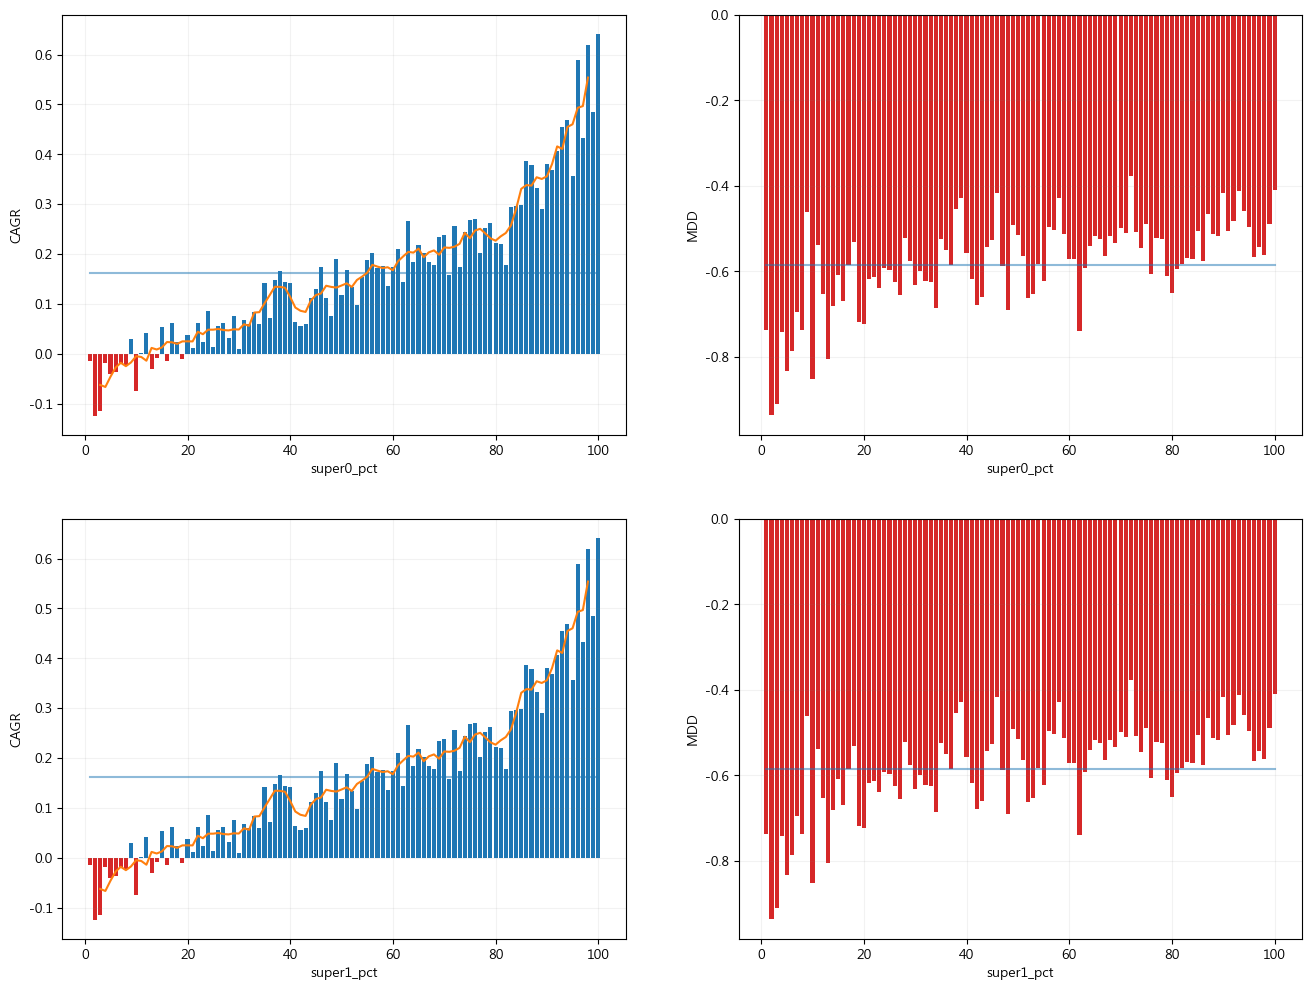

In [19]:
import matplotlib.pyplot as plt
from core.base.quantutil import cagr, mdd
from base.timeutil import YearMonth
from datetime import date

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10000

target_factors = [f for f in factors if f.startswith("super")]
fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(16), fig.set_figheight(6 * len(target_factors))

summary = pd.DataFrame()
for i in range(len(target_factors)):
    print(f"\r{i + 1}/{len(target_factors)}", end="")
    factor = factors[i]
    colname_pct = f"{factor}_pct"
    percentiles = sorted(set(result[colname_pct].dropna()))
    mean_by_pct = []
    cagr_by_pct = []
    mdd_by_pct = []
    for pct in percentiles:
        by_pct = result[result[colname_pct] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        begin = YearMonth.from_string(by_pct["매수년월"].min())
        cumprod = (return_by_ym + 1).cumprod()
        last = cumprod[-1]
        mean_by_pct.append(return_by_ym.mean())
        cagr_by_pct.append(cagr(1, last, by_pct["매도년월"].unique().size / 12))
        dates = [date(int(s.split("-")[0]), int(s.split("-")[1]), 1) for s in return_by_ym.index]
        mdd_by_pct.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]

    cagr_by_pct_series = pd.Series(cagr_by_pct)
    mdd_by_pct_series = pd.Series(mdd_by_pct)

    ax1.set_xlabel(colname_pct)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(percentiles, cagr_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_pct])
    ax1.plot(percentiles, [cagr_by_pct_series.mean() for _ in percentiles], alpha=0.5)
    ax1.plot(percentiles, cagr_by_pct_series.rolling(5, center=True).mean())

    ax2.set_xlabel(colname_pct)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(percentiles, mdd_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_pct])
    ax2.plot(percentiles, [mdd_by_pct_series.mean() for _ in percentiles], alpha=0.5)

    corr = pd.DataFrame({colname_pct: percentiles, "cagr": cagr_by_pct}).corr(method="spearman")
    cagr_by_pct_desc = cagr_by_pct_series[cagr_by_pct_series.index.sort_values(ascending=False)]
    mdd_by_pct_desc = mdd_by_pct_series[mdd_by_pct_series.index.sort_values(ascending=False)]
    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": corr[colname_pct]["cagr"],
            "top": cagr_by_pct_desc.head(1).mean(),
            "h3": cagr_by_pct_desc.head(3).mean(),
            "h5": cagr_by_pct_desc.head(5).mean(),
            "h10": cagr_by_pct_desc.head(10).mean(),
            "t5": cagr_by_pct_desc.tail(5).mean(),
            "h5-t5": cagr_by_pct_desc.head(5).mean() - cagr_by_pct_desc.tail(5).mean(),
            "h5-t5+mdd5": cagr_by_pct_desc.head(5).mean() - cagr_by_pct_desc.tail(
                5).mean() + mdd_by_pct_desc.head(5).mean(),
            "mean": cagr_by_pct_desc.mean(),
            "median": cagr_by_pct_desc.median(),
            "mdd5": mdd_by_pct_desc.head(5).mean(),
        }).to_frame(factor).T
    ])

print()
print(result["매수년월"].min(), result["매도년월"].max())
print(pd.DataFrame(recipes))

summary.index.name = "factor"
summary.to_sql("sfw", sqlite3.connect(".cache/cache.db"), if_exists="replace")
summary = summary.sort_values("h5", ascending=False)
summary

In [21]:
_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "super0"
print(recipes[0])
head = 20
result2 = result[~result["종목명"].str.endswith("홀딩스")]
result2 = result2[~result2["종목명"].str.endswith("지주")]
# result2 = result2[result2["1/P"].rank(ascending=False, method="min", pct=True) < 0.3]

strategy = result2.groupby(_key).apply(
    lambda values: values.sort_values(factor, ascending=False).head(head)["수익률"].mean())
strategy = pd.Series(strategy, index=benchmark.index).fillna(0)
result2.groupby(_key).apply(lambda values: values.sort_values(factor, ascending=False).head(head))[
    ["code", "종목명", "수익률", "거래소", "매수일", "매도일", "매수가", "매도가", factor]]

{'GP/P': 8, 'P': -8, 'GP_YoY': 1, 'GP_QoQ': 2, 'O_YoY': 1, 'O_QoQ': 2}


code     종목명       수익률     거래소         매수일  \
매수년월    매도년월                                                           
2002-06 2002-07 458     006090    사조오양 -0.023342   KOSPI  2002-06-28   
                877     003960    사조대림 -0.036108   KOSPI  2002-06-28   
                28      017550   수산중공업 -0.165746   KOSPI  2002-06-28   
                255     033540     파라텍 -0.031746  KOSDAQ  2002-06-28   
                82      027740     마니커 -0.042055   KOSPI  2002-06-28   
...                        ...     ...       ...     ...         ...   
2022-10 2022-11 373264  017370   우신시스템  0.242830   KOSPI  2022-10-31   
                373665  111110    호전실업  0.137931   KOSPI  2022-10-31   
                372404  084870  TBH글로벌  0.143275   KOSPI  2022-10-31   
                372542  038060     루멘스  0.090476  KOSDAQ  2022-10-31   
                372618  000500    가온전선  0.095808   KOSPI  2022-10-31   

                               매도일    매수가      매도가     super0  
매수년월    매도년월                                                   
2002-06 2002-07 458     2002-07-31   1885   1841.0  58.727273  
                877     2002-07-31  34452  33208.0  57.545455  
                28      2002-07-31    362    302.0  56.409091  
                255     2002-07-31     63     61.0  55.909091  
                82      2002-07-31   3329   3189.0  54.772727  
...                            ...    ...      ...        ...  
2022-10 2022-11 373264  2022-11-30   2615   3250.0  48.636364  
                373665  2022-11-30   7250   8250.0  48.500000  
                372404  2022-11-30   1710   1955.0  48.090909  
                372542  2022-11-30   1050   1145.0  47.227273  
                372618  2022-11-30  16700  18300.0  46.454545  

[4900 rows x 9 columns]

In [22]:
from core.base.quantutil import cagr, mdd
from base.timeutil import YearMonth

revisions = pd.DataFrame({
    "벤치마크 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": round(strategy - benchmark, 2),
    "벤치마크 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod()
})


def str_to_ym(_s: str):
    _sp = _s.split("-")
    return YearMonth(int(_sp[0]), int(_sp[1]))


begin = str_to_ym(revisions.index[0][0])
end = str_to_ym(revisions.index[-1][-1])
years = (end.value() - begin.value()) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"][-1], years), cagr(1, revisions["벤치마크 누적수익률"][-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions.index], revisions["전략 누적수익률"]),
            mdd([i2 for _, i2 in revisions.index], revisions["벤치마크 누적수익률"])],
    "Mean": [revisions["전략 수익률"].mean(), revisions["벤치마크 수익률"].mean()]
}, index=["전략", "벤치마크"])
print(summary)

revisions

          CAGR                                         MDD      Mean
전략    0.638452  (-0.41035602324713927, (2007-09, 2008-10))  0.046610
벤치마크  0.162165   (-0.5373814900711391, (2007-07, 2008-10))  0.014945


,,벤치마크 수익률,전략 수익률,성능,벤치마크 누적수익률,전략 누적수익률
매수년월,매도년월,,,,,
2002-06,2002-07,-0.002524,0.010345,0.01,0.997476,1.010345
2002-07,2002-08,0.034868,0.091168,0.06,1.032256,1.102457
2002-08,2002-09,-0.149046,-0.045798,0.10,0.878402,1.051966
2002-09,2002-10,0.045796,0.005143,-0.04,0.918630,1.057377
2002-10,2002-11,0.052133,0.003533,-0.05,0.966520,1.061112
...,...,...,...,...,...,...
2022-06,2022-07,0.064967,0.098208,0.03,22.864009,24290.127727
2022-07,2022-08,0.007833,-0.010734,-0.02,23.043097,24029.401225
2022-08,2022-09,-0.154665,-0.174991,-0.02,19.479140,19824.466590


전체 개월 수      245.00
초과수익 개월 수    166.00
아웃퍼폼 총합        9.35
언더퍼폼 총합       -1.65
dtype: float64

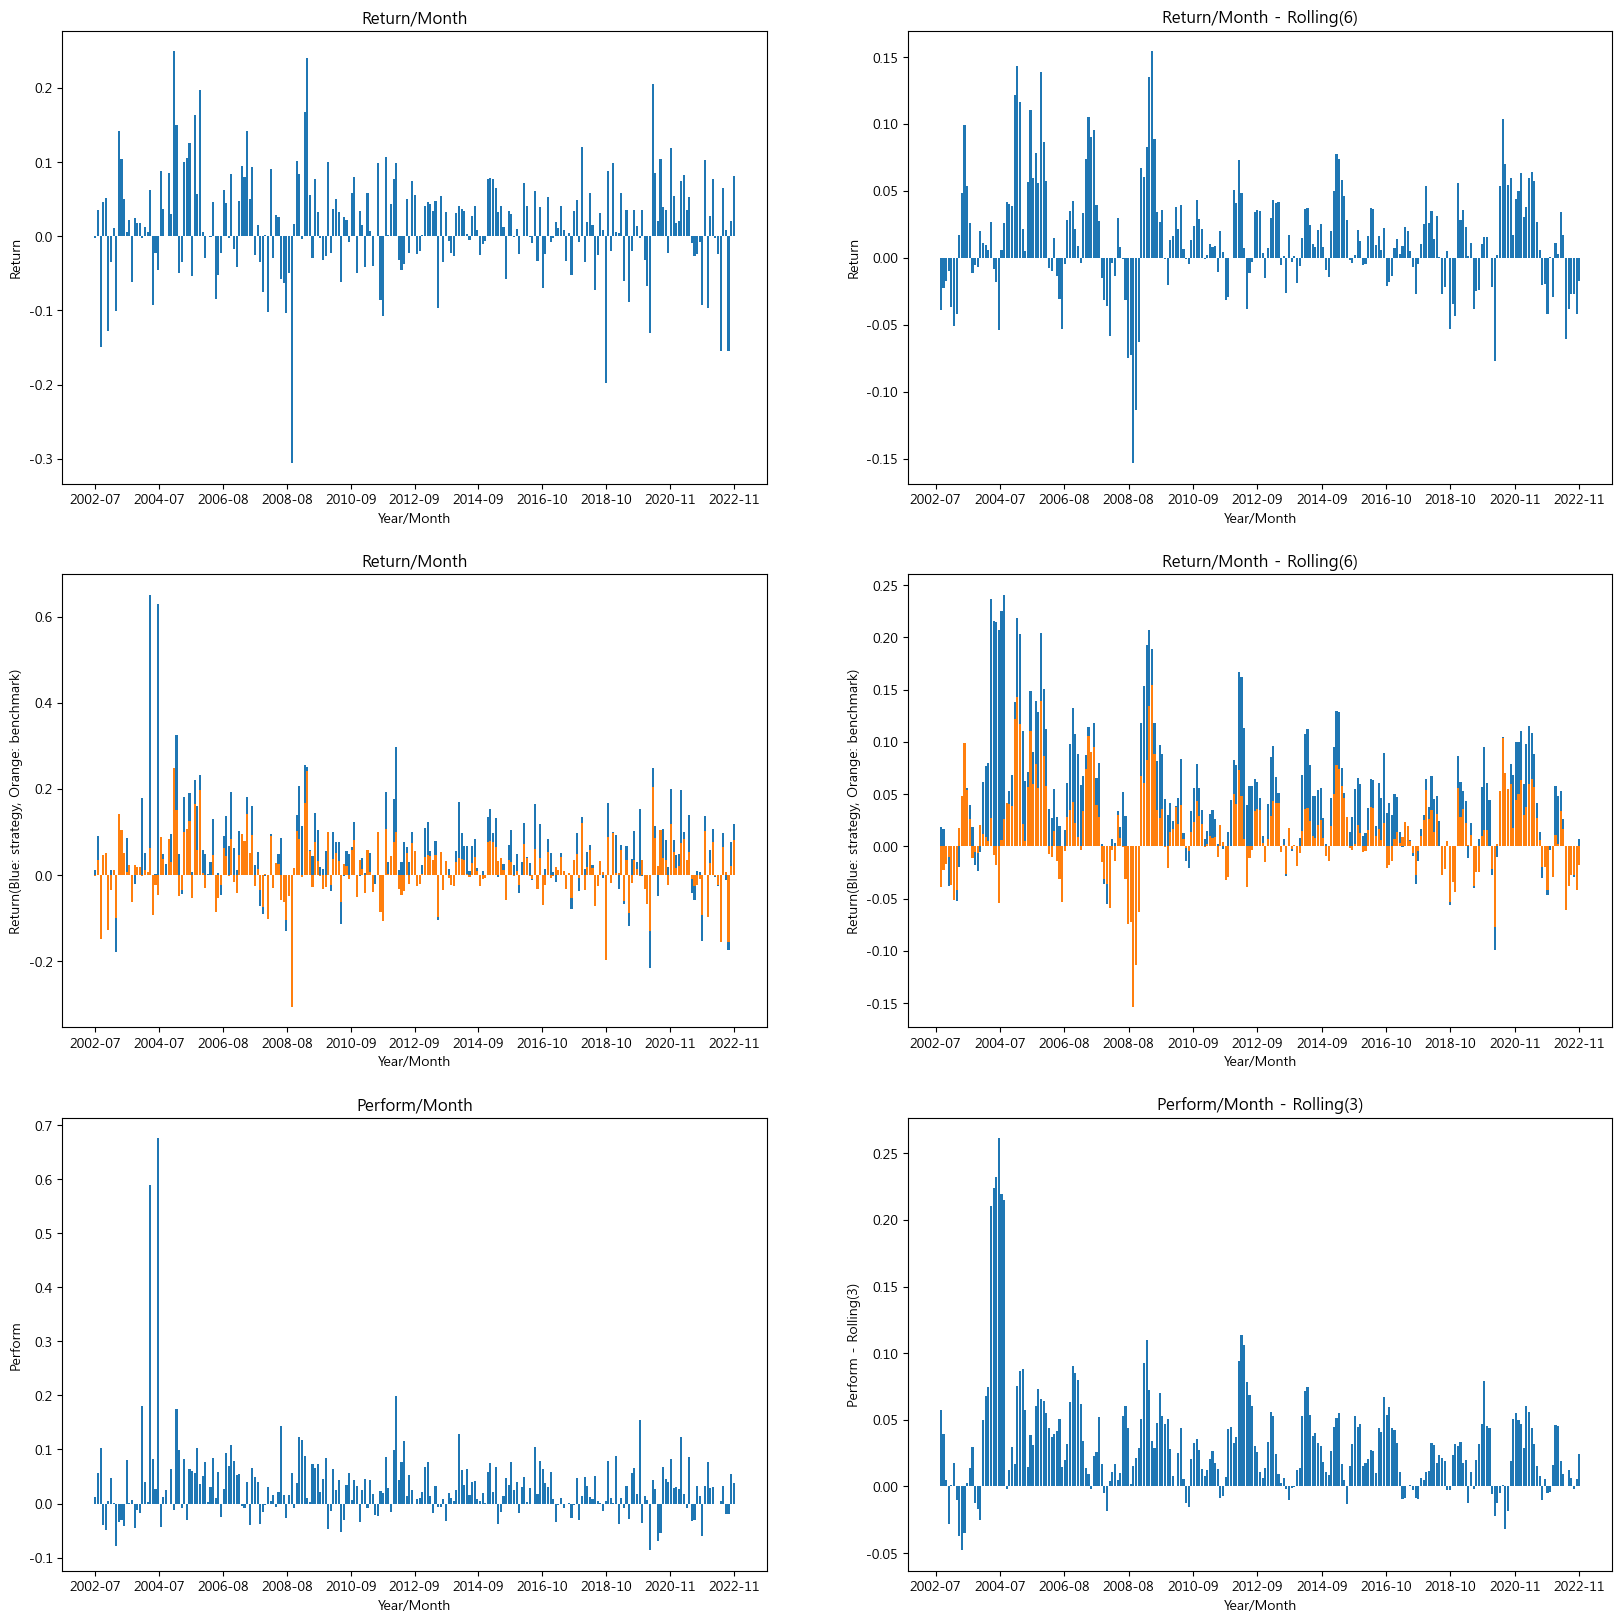

In [23]:
import numpy as np
import matplotlib.pyplot as plt

months = [i for _, i in strategy.index]

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"Return/Month")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["벤치마크 수익률"])

window = 3
ax2.set_title("Return/Month - Rolling(6)")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["벤치마크 수익률"].rolling(window).mean())

ax3.set_title(f"Return/Month")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax3.bar(months, revisions["전략 수익률"])
ax3.bar(months, revisions["벤치마크 수익률"])

ax4.set_title("Return/Month - Rolling(6)")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax4.bar(months, revisions["전략 수익률"].rolling(window).mean())
ax4.bar(months, revisions["벤치마크 수익률"].rolling(window).mean())

ax5.set_title("Perform/Month")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["전략 수익률"] - revisions["벤치마크 수익률"])

ax6.set_title(f"Perform/Month - Rolling({window})")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({window})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax6.bar(months, (revisions["전략 수익률"] - revisions["벤치마크 수익률"]).rolling(window).mean())

pd.Series({
    "전체 개월 수": len(revisions),
    "초과수익 개월 수": len(revisions[revisions["성능"] > 0]),
    "아웃퍼폼 총합": revisions[revisions["성능"] > 0]["성능"].sum(),
    "언더퍼폼 총합": revisions[revisions["성능"] < 0]["성능"].sum()
})